In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
import h5py
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm  # Importa a biblioteca tqdm para barras de progresso

# Caminho do arquivo FITS
file_fits = "C:\\Users\\stefa\\OneDrive\\Documentos\\NATALI TCC\\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"

# Abrir o arquivo FITS
hdulist = fits.open(file_fits)

# Acessar o cabeçalho do primeiro HDU (hdu[0])
header = hdulist[0].header

# Extrai os dados dos HDUs
data_hdu0 = hdulist[0].data
data_hdu1 = hdulist[1].data

# Cria as listas de merge e non-merge
list_of_mergers = []
list_of_nonmergers = []

# Itera sobre os dados do HDU 1 e classifica as imagens com barra de progresso
for i in tqdm(range(len(data_hdu1)), desc="Classificando imagens"):
    if data_hdu1[i][0] == 0:  # Acessa o elemento da tupla
        list_of_mergers.append(i)
    else:
        list_of_nonmergers.append(i)

# Salva as listas em arquivos HDF5
with h5py.File("list_of_mergers.hdf5", "w") as f:
    f.create_dataset("mergers", data=np.array(list_of_mergers))

with h5py.File("list_of_nonmergers.hdf5", "w") as f:
    f.create_dataset("non_mergers", data=np.array(list_of_nonmergers))

# Carrega os IDs dos arquivos HDF5
with h5py.File("list_of_mergers.hdf5", "r") as f:
    mergers_ids = f["mergers"][:]
with h5py.File("list_of_nonmergers.hdf5", "r") as f:
    non_mergers_ids = f["non_mergers"][:]

# Cria o conjunto de dados X (imagens) e Y (labels)
X = data_hdu0[mergers_ids]
Y = np.zeros(len(mergers_ids)) 

X_non_merges = data_hdu0[non_mergers_ids]
Y_non_merges = np.ones(len(non_mergers_ids))

# Combina os conjuntos de dados
X = np.concatenate((X, X_non_merges))
Y = np.concatenate((Y, Y_non_merges))

# Transposição dos dados para o formato "channels_last"
X = X.transpose(0, 2, 3, 1)  

# Normalização dos dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1))
X = X.reshape(X.shape[0], 75, 75, 2) 

# Divisão dos dados em treino, teste e validação
random_seed = 42
X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, test_size=0.3, random_state=random_seed)
X_test, X_val, Y_test, Y_val = train_test_split(X_rem, Y_rem, test_size=1/3, random_state=random_seed)

# Aumento de dados usando ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Aplica o aumento de dados ao conjunto de treinamento
X_train_augmented = datagen.flow(X_train, Y_train, batch_size=len(X_train), shuffle=True).__next__()

# Aplica o aumento de dados ao conjunto de teste
X_test_augmented = datagen.flow(X_test, Y_test, batch_size=len(X_test), shuffle=True).__next__()

# Aplica o aumento de dados ao conjunto de validação
X_val_augmented = datagen.flow(X_val, Y_val, batch_size=len(X_val), shuffle=True).__next__()

# Salva os dados pré-processados
np.save("X_train.npy", X_train_augmented[0])
np.save("Y_train.npy", X_train_augmented[1])
np.save("X_test.npy", X_test_augmented[0])
np.save("Y_test.npy", X_test_augmented[1])
np.save("X_val.npy", X_val_augmented[0])
np.save("Y_val.npy", X_val_augmented[1])

# Imprime o tamanho e o shape
print("Conjunto de Treinamento:")
print(f"Tamanho de X_train: {X_train_augmented[0].shape[0]}")
print(f"Shape de X_train: {X_train_augmented[0].shape}")
print(f"Tamanho de Y_train: {X_train_augmented[1].shape[0]}")
print(f"Shape de Y_train: {X_train_augmented[1].shape}")

print("\nConjunto de Teste:")
print(f"Tamanho de X_test: {X_test_augmented[0].shape[0]}")
print(f"Shape de X_test: {X_test_augmented[0].shape}")
print(f"Tamanho de Y_test: {X_test_augmented[1].shape[0]}")
print(f"Shape de Y_test: {X_test_augmented[1].shape}")

print("\nConjunto de Validação:")
print(f"Tamanho de X_val: {X_val_augmented[0].shape[0]}")
print(f"Shape de X_val: {X_val_augmented[0].shape}")
print(f"Tamanho de Y_val: {X_val_augmented[1].shape[0]}")
print(f"Shape de Y_val: {X_val_augmented[1].shape}")

hdulist.close()

Classificando imagens: 100%|██████████████████████████████████████████████████| 15426/15426 [00:01<00:00, 14532.41it/s]


Conjunto de Treinamento:
Tamanho de X_train: 10798
Shape de X_train: (10798, 75, 75, 2)
Tamanho de Y_train: 10798
Shape de Y_train: (10798,)

Conjunto de Teste:
Tamanho de X_test: 3085
Shape de X_test: (3085, 75, 75, 2)
Tamanho de Y_test: 3085
Shape de Y_test: (3085,)

Conjunto de Validação:
Tamanho de X_val: 1543
Shape de X_val: (1543, 75, 75, 2)
Tamanho de Y_val: 1543
Shape de Y_val: (1543,)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import json
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [4]:
# Define a camada de entrada (com 2 canais)
input_tensor = layers.Input(shape=(75, 75, 2)) 

In [5]:
# Camadas convolucionais
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = layers.Dropout(0.4)(x)

# Camadas densas
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))(x)
x = layers.Dropout(0.5)(x)

# Camada de saída
output_tensor = layers.Dense(1, activation='sigmoid')(x)

In [6]:
# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

In [7]:
# Parâmetros de compilação
optimizer = Adam(learning_rate=0.0001) # Experimentar com outras taxas
metrics = ['accuracy']
loss = 'binary_crossentropy'

In [8]:
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [9]:
# Caminho para salvar checkpoints
checkpoint_filepath = 'melhor_modelo_pesos.weights.keras'

In [10]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=30, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=30,
    min_lr=1e-05
)

# Combine callbacks into a list:
callbacks = [checkpoint, early_stopping, reduce_lr]

In [11]:
# Carregar dados pré-processados
X_train_augmented = np.load("X_train.npy")
Y_train_augmented = np.load("Y_train.npy")
X_val_augmented = np.load("X_val.npy")
Y_val_augmented = np.load("Y_val.npy")
X_test_augmented = np.load("X_test.npy")
Y_test_augmented = np.load("Y_test.npy")

# Imprimir formatos dos dados
print("Formato de X_train:", X_train_augmented.shape)
print("Formato de Y_train:", Y_train_augmented.shape)
print("Formato de X_val:", X_val_augmented.shape)
print("Formato de Y_val:", Y_val_augmented.shape)
print("Formato de X_test:", X_test_augmented.shape)
print("Formato de Y_test:", Y_test_augmented.shape)

Formato de X_train: (10798, 75, 75, 2)
Formato de Y_train: (10798,)
Formato de X_val: (1543, 75, 75, 2)
Formato de Y_val: (1543,)
Formato de X_test: (3085, 75, 75, 2)
Formato de Y_test: (3085,)


In [12]:
# Treinar o modelo
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_val, Y_val),
    shuffle=True,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5191 - loss: 1.6532
Epoch 1: val_accuracy improved from -inf to 0.47764, saving model to melhor_modelo_pesos.weights.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 32s 59ms/step - accuracy: 0.5191 - loss: 1.6529 - val_accuracy: 0.4776 - val_loss: 1.2420 - learning_rate: 1.0000e-04
Epoch 2/100
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5141 - loss: 1.4118
Epoch 2: val_accuracy improved from 0.47764 to 0.56384, saving model to melhor_modelo_pesos.weights.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5141 - loss: 1.4116 - val_accuracy: 0.5638 - val_loss: 1.1949 - learning_rate: 1.0000e-04
Epoch 3/100
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5350 - loss: 1.3174
Epoch 3: val_accuracy did not improve from 0.56384
338/338 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - accuracy: 0.5349 - loss: 1.3173 - val_accuracy: 0.5489 - val_loss: 1.1899 - learning_rate: 1.0000e-04
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━

In [13]:
# Salvar histórico, pesos e modelo
with open("history.json", "w") as f:
    json.dump(history.history, f)

model.save_weights("pesos_modelo.weights.h5")
model.save("modelo.keras")

# Carregar modelo salvo (apenas uma vez)
loaded_model = load_model("modelo.keras")

# Criar otimizador rmsprop (apenas uma vez)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)

# Compilar o modelo com a função de perda correta
loaded_model.compile(
    optimizer=rmsprop,
    loss='binary_crossentropy',  # Utilize 'binary_crossentropy' para classificação binária
    metrics=['accuracy']
)

In [14]:
# Imprimir a acurácia do modelo carregado
accuracy = loaded_model.evaluate(X_test, Y_test, verbose=0)[1]  # Use os dados de teste aqui
print(f"Acurácia do modelo carregado: {accuracy * 100:.2f}%") 

Acurácia do modelo carregado: 77.12%


In [15]:
# Imprime o histórico
print(history.history)

{'accuracy': [0.5206519961357117, 0.5221337080001831, 0.5276902914047241, 0.5403778553009033, 0.5448231101036072, 0.5626041889190674, 0.5576958656311035, 0.566123366355896, 0.5759400129318237, 0.593165397644043, 0.592702329158783, 0.5993702411651611, 0.6083533763885498, 0.6174291372299194, 0.6133543252944946, 0.6195591688156128, 0.6249305605888367, 0.6365067362785339, 0.6408594250679016, 0.6343767642974854, 0.6342841386795044, 0.6453973054885864, 0.6454899311065674, 0.6493794918060303, 0.654009997844696, 0.6527134776115417, 0.6548435091972351, 0.6553991436958313, 0.6624374985694885, 0.6670680046081543, 0.6739211082458496, 0.6684571504592896, 0.675958514213562, 0.6737358570098877, 0.6790146231651306, 0.6805890202522278, 0.6861456036567688, 0.6809594631195068, 0.6893869042396545, 0.6924430727958679, 0.6962400674819946, 0.6872568726539612, 0.6950361132621765, 0.6906834840774536, 0.7022596597671509, 0.703370988368988, 0.7010557651519775, 0.7055936455726624, 0.7051305770874023, 0.7142989635

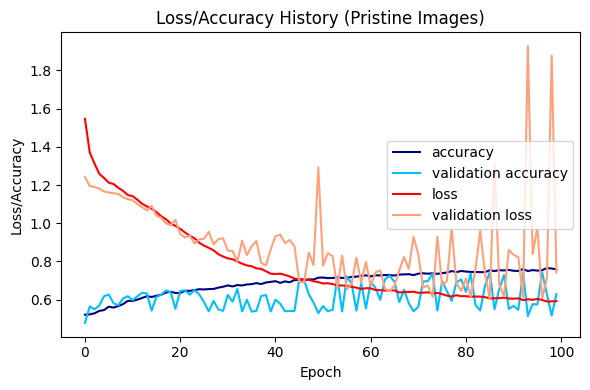

In [16]:
# Plotar histórico
with open("history.json", "r") as f:
    history_data = json.load(f)

loss = history_data['loss']
val_loss = history_data['val_loss']
acc = history_data['accuracy']
val_acc = history_data['val_accuracy']

epochs = list(range(len(loss)))
figsize=(6,4)
fig, axis1 = plt.subplots(figsize=figsize)

plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")
plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")

plots = plot1_loss + plot1_val_loss + plot1_lacc + plot1_val_lacc
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (Pristine Images)")
plt.tight_layout()
axis1.legend(loc='center right')

plt.show()

In [17]:
import tensorflow as tf
from tqdm import tqdm  # Importa a biblioteca tqdm

BATCH_SIZE = 32
loss_function = tf.keras.losses.BinaryCrossentropy()  # Define a função de perda

# Cria um dataset a partir dos dados de treinamento
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

# Itera sobre as épocas
for epoch in range(50):
    # Calcula o gradiente em batches
    for batch_x, batch_y in tqdm(train_dataset, total=X_train.shape[0] // BATCH_SIZE, desc=f"Epoch {epoch+1}"):
        with tf.GradientTape() as tape:
            predictions = model(batch_x)
            loss = loss_function(batch_y, predictions)

        # Calcula o gradiente
        gradients = tape.gradient(loss, model.trainable_variables)

        # Imprime o gradiente
        # print(f"Epoch {epoch+1}, Batch: {batch_x.shape[0]}")
        # for var, grad in zip(model.trainable_variables, gradients):
        #     print(f"Variable: {var.name}, Gradient: {grad}")

        # Aplica o gradiente (opcional)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 1: 338it [01:42,  3.30it/s]                                                                                      
Epoch 2: 338it [01:40,  3.36it/s]                                                                                      
Epoch 3: 338it [01:42,  3.31it/s]                                                                                      
Epoch 4: 338it [01:40,  3.36it/s]                                                                                      
Epoch 5: 338it [01:39,  3.38it/s]                                                                                      
Epoch 6: 338it [01:39,  3.40it/s]                                                                                      
Epoch 7: 338it [01:40,  3.36it/s]                                                                                      
Epoch 8: 338it [01:40,  3.35it/s]                                                                                      
Epoch 9: 338it [01:40,  3.36it/s]       

In [18]:
import json
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

In [19]:
# Carregar histórico
with open("history.json", "r") as f:
    history_data = json.load(f)

# predict
prob = loaded_model.predict(X_test)
pred =  (prob > 0.5).astype('int32') 

# measure confusion
labels=[0, 1]
cm = confusion_matrix(Y_test, pred[:,0], labels=labels)  # Use Y_test aqui
cm = cm.astype('float')
cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
print("cm", cm)
print("\n cm_norm", cm_norm)

fpr, tpr, thresholds = roc_curve(Y_test, prob, pos_label=1)  # Use Y_test aqui
auc = roc_auc_score(Y_test, prob)
print("\n AUC:", auc)

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
cm [[ 982.  482.]
 [ 224. 1397.]]

 cm_norm [[0.67076503 0.32923497]
 [0.1381863  0.8618137 ]]

 AUC: 0.8491094514281476


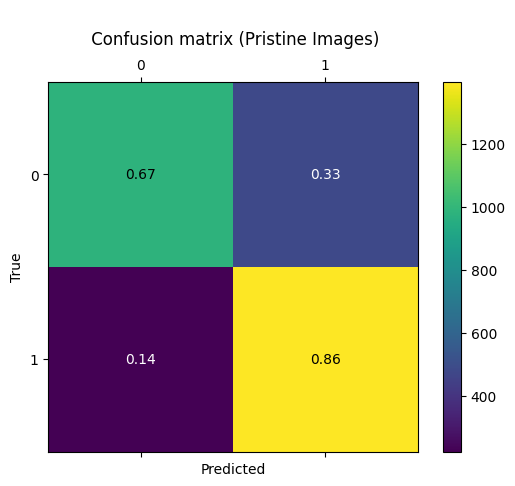

In [20]:
#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('\n Confusion matrix (Pristine Images)', y=1.08)
fig.colorbar(cax)

# Defina as posições dos ticks
ax.set_xticks([0, 1])  # Define as posições dos ticks no eixo x
ax.set_yticks([0, 1])  # Define as posições dos ticks no eixo y

# Agora defina as labels dos ticks
ax.set_xticklabels(labels)  # Remove o elemento vazio da lista
ax.set_yticklabels(labels)  # Remove o elemento vazio da lista

plt.xlabel('Predicted')
plt.ylabel('True')
fmt = '.2f'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
        ha="center", va="center",
        color="white" if cm_norm[i, j] < thresh else "black")
plt.show()

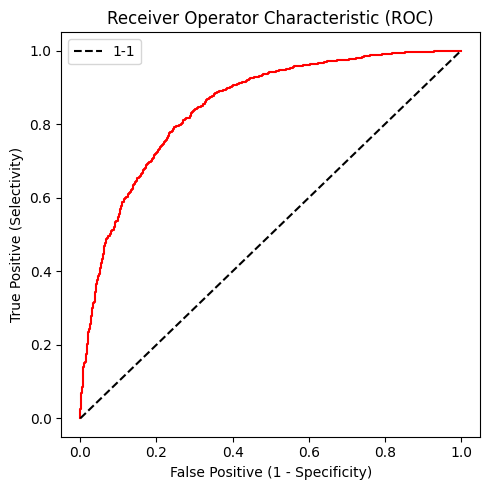

In [21]:
# ROC TEST SET
figsize=(5,5)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]
plt.plot(fpr, tpr, 'r-')
plt.plot(x_onetoone, y_onetoone, 'k--',  label="1-1")
plt.legend(loc=0)
plt.title("Receiver Operator Characteristic (ROC)")
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()

In [22]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, pred[:,0])  # Access the first column
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(Y_test, pred[:,0])  # Access the first column
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(Y_test, pred[:,0])  # Access the first column
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, pred[:,0])  # Access the first column
print('F1 score: %f' % f1)

# brier score
bs = brier_score_loss(Y_test, prob)
print('Brier score: %f' % bs)

Accuracy: 0.771151
Precision: 0.743481
Recall: 0.861814
F1 score: 0.798286
Brier score: 0.164780


In [23]:
# seraching for examples
for i in range(len(Y_test)):
    if (Y_test[i] == 1 and pred[i,0] == 1): # and other y_test vs pered combinations TP=(1,1), FP=(0,1), TN=(0,0), FN=(1,0)
        print (i)
        print(Y_test[i],pred[i,0]) # Access the first column of pred

0
1.0 1
2
1.0 1
8
1.0 1
9
1.0 1
10
1.0 1
11
1.0 1
12
1.0 1
14
1.0 1
18
1.0 1
22
1.0 1
24
1.0 1
30
1.0 1
31
1.0 1
34
1.0 1
43
1.0 1
48
1.0 1
50
1.0 1
51
1.0 1
54
1.0 1
56
1.0 1
61
1.0 1
62
1.0 1
63
1.0 1
64
1.0 1
65
1.0 1
66
1.0 1
68
1.0 1
70
1.0 1
71
1.0 1
75
1.0 1
76
1.0 1
78
1.0 1
79
1.0 1
80
1.0 1
81
1.0 1
83
1.0 1
85
1.0 1
87
1.0 1
88
1.0 1
90
1.0 1
92
1.0 1
93
1.0 1
96
1.0 1
98
1.0 1
99
1.0 1
100
1.0 1
106
1.0 1
107
1.0 1
110
1.0 1
111
1.0 1
113
1.0 1
115
1.0 1
117
1.0 1
118
1.0 1
123
1.0 1
124
1.0 1
125
1.0 1
126
1.0 1
127
1.0 1
130
1.0 1
131
1.0 1
132
1.0 1
134
1.0 1
136
1.0 1
143
1.0 1
146
1.0 1
147
1.0 1
148
1.0 1
150
1.0 1
154
1.0 1
155
1.0 1
157
1.0 1
159
1.0 1
160
1.0 1
161
1.0 1
162
1.0 1
163
1.0 1
164
1.0 1
167
1.0 1
171
1.0 1
172
1.0 1
173
1.0 1
174
1.0 1
178
1.0 1
179
1.0 1
180
1.0 1
182
1.0 1
184
1.0 1
187
1.0 1
188
1.0 1
190
1.0 1
191
1.0 1
192
1.0 1
198
1.0 1
200
1.0 1
201
1.0 1
203
1.0 1
205
1.0 1
206
1.0 1
207
1.0 1
208
1.0 1
210
1.0 1
211
1.0 1
221
1.0 1
224
1.0 1

In [24]:
#print output probabilities for the chosen TP, FP, TN, FN examples
print(prob[84],prob[1370],prob[2031],prob[3003]) # TP examples
print(prob[560],prob[1228],prob[2878],prob[3026]) # FP examples
print(prob[564],prob[1056],prob[2083],prob[3063]) # TN examples
print(prob[465],prob[1546],prob[2241],prob[3037]) # FN examples

[0.09789231] [0.86195856] [0.9752553] [0.38924837]
[0.7947322] [0.9563236] [0.631051] [0.61128604]
[0.9008238] [0.7082504] [0.22102445] [0.8776178]
[0.16410758] [0.7535885] [0.3295688] [0.5113022]


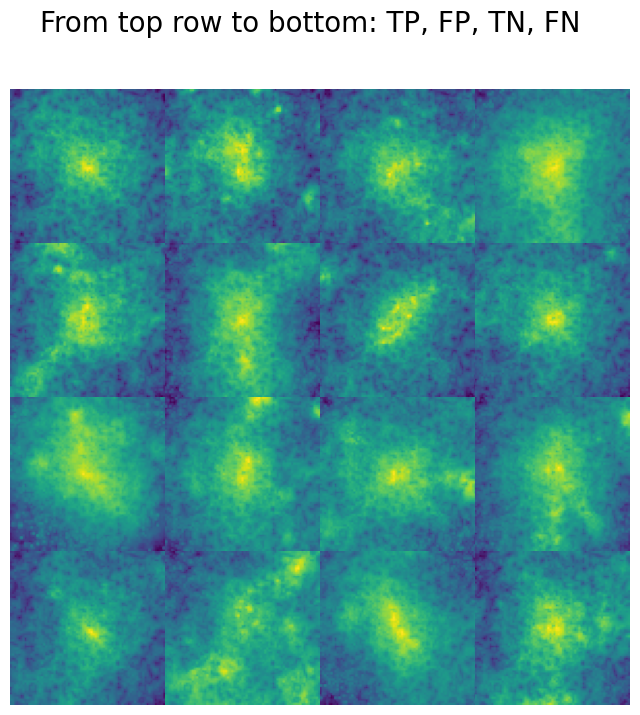

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# ... (código anterior para carregar dados, etc.)

# plot examples
tp1 = X_test[84]  # Acessa toda a imagem do exemplo 84
tp2 = X_test[1370]
tp3 = X_test[2031]
tp4 = X_test[3003]

fp1 = X_test[560]
fp2 = X_test[1228]
fp3 = X_test[2878]
fp4 = X_test[3026]

tn1 = X_test[564]
tn2 = X_test[1056]
tn3 = X_test[2083]
tn4 = X_test[3063]

fn1 = X_test[465]
fn2 = X_test[1546]
fn3 = X_test[2241]
fn4 = X_test[3037]

examples = [tp1, tp2, tp3, tp4, fp1, fp2, fp3, fp4, tn1, tn2, tn3, tn4, fn1, fn2, fn3, fn4]

# Aplica a normalização logarítmica
examples = [np.log(image + 1) for image in examples]  

fig1=plt.figure(figsize=(8,8))

for i, image in enumerate(examples):
    fig1.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=20)
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    # Combine os canais em uma única imagem
    combined_image = np.mean(image, axis=2) 
    plt.imshow(combined_image, aspect='auto', cmap='viridis', norm=LogNorm()) 
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

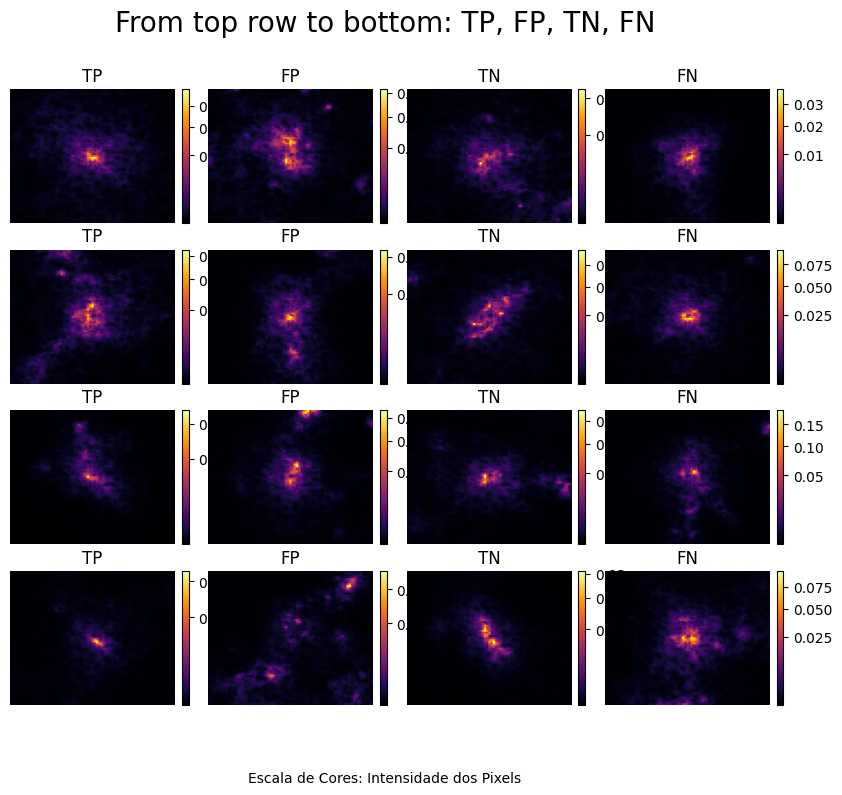

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, PowerNorm

fig1 = plt.figure(figsize=(10, 8))  # Ajuste o tamanho da figura

for i, image in enumerate(examples):
    # Define os rótulos
    labels = ['TP', 'FP', 'TN', 'FN']
    label = labels[i % len(labels)] 

    fig1.suptitle('From top row to bottom: TP, FP, TN, FN', fontsize=20)
    plt.subplot(4, 4, i + 1)
    plt.axis("off")

    # Combine os canais em uma única imagem
    combined_image = np.mean(image, axis=2)

    # Ajuste de Contraste:
    norm = PowerNorm(gamma=0.5) 

    # Plota a imagem
    img = plt.imshow(combined_image, aspect='auto', cmap='inferno', norm=norm) 
    plt.title(label, fontsize=12)  # Adiciona o rótulo

    # Adiciona uma barra de cores
    plt.colorbar(img, fraction=0.046, pad=0.04) 

# Ajusta o espaçamento entre as subplots
plt.subplots_adjust(hspace=0.2, wspace=0.1)  

# Adiciona a explicação da escala na parte inferior da figura
plt.figtext(
    0.5, 0.01, "Escala de Cores: Intensidade dos Pixels", ha="center", va="bottom", fontsize=10
)

plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, PowerNorm
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

In [28]:
# Carregar os dados de labels completos
Y_test = np.load("Y_test.npy")

# Realizar a subamostragem dos dados de labels usando StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index, test_index in splitter.split(X_test, Y_test):
    indices_da_subamostra = test_index
    Y_sub_test = Y_test[indices_da_subamostra]

list_past = []
list_future = []
list_nonmerger = []
for i in range(len(Y_sub_test)):
    if Y_sub_test[i] == 1: 
        list_past.append(prob[i])
    if Y_sub_test[i] == 1: 
        list_future.append(prob[i])
    if Y_sub_test[i] == 0: 
        list_nonmerger.append(prob[i])
past = np.stack(list_past)
future = np.stack(list_future)
non = np.stack(list_nonmerger)

# Imprimir alguns resultados
print("Primeiros 5 elementos de 'past':", past[:5])
print("Primeiros 5 elementos de 'future':", future[:5])
print("Primeiros 5 elementos de 'non':", non[:5])

Primeiros 5 elementos de 'past': [[0.69871616]
 [0.8052138 ]
 [0.73220205]
 [0.81805193]
 [0.93011963]]
Primeiros 5 elementos de 'future': [[0.69871616]
 [0.8052138 ]
 [0.73220205]
 [0.81805193]
 [0.93011963]]
Primeiros 5 elementos de 'non': [[0.6799963 ]
 [0.70423603]
 [0.48432356]
 [0.2496125 ]
 [0.15843654]]


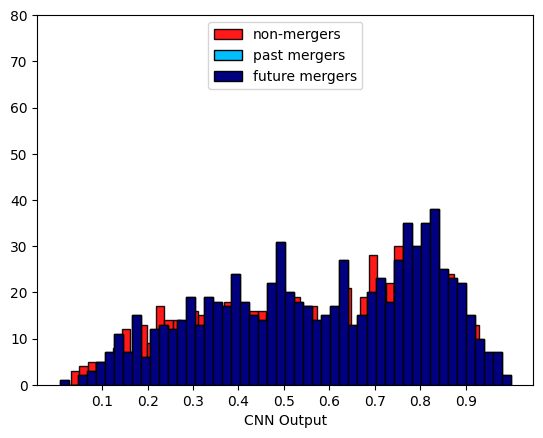

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, PowerNorm

# plot histogram
bins = 50
plt.hist(non, bins, alpha=0.9, label='non-mergers', color='red', edgecolor='black', linewidth=1)
plt.hist(past, bins, alpha=1, label='past mergers', color='deepskyblue', edgecolor='black', linewidth=1)
plt.hist(future, bins, alpha=1, label='future mergers', color='navy', edgecolor='black', linewidth=1)
plt.legend(loc='upper center')
plt.xticks(np.arange(0.1, 1.0, step=0.1)) # Ajuste a escala do eixo x
plt.yticks(np.arange(0, 81, step=10)) # Ajuste a escala do eixo y para 0 a 80
plt.xlabel("CNN Output")
plt.show()

In [30]:
# Cria um modelo para extrair as ativações
layer_outputs = [layer.output for layer in loaded_model.layers[1:]] 
activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs)

# Faz previsões para as imagens de teste
activations = activation_model.predict(X_test_augmented) 

97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


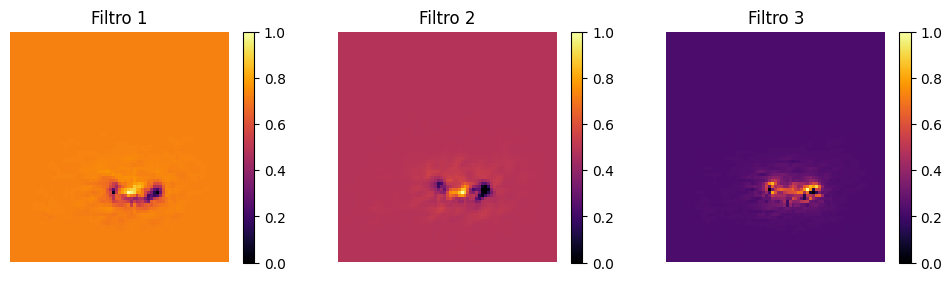

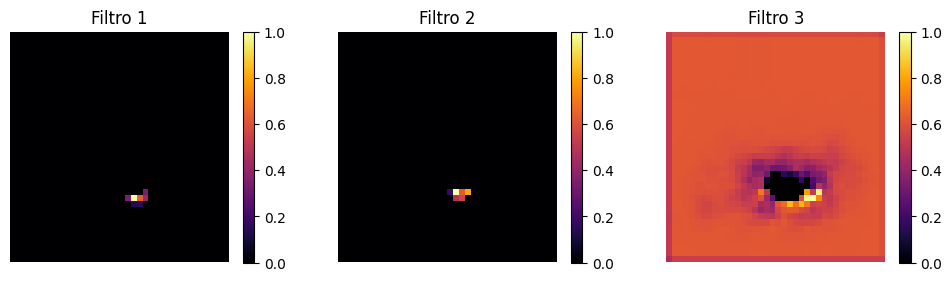

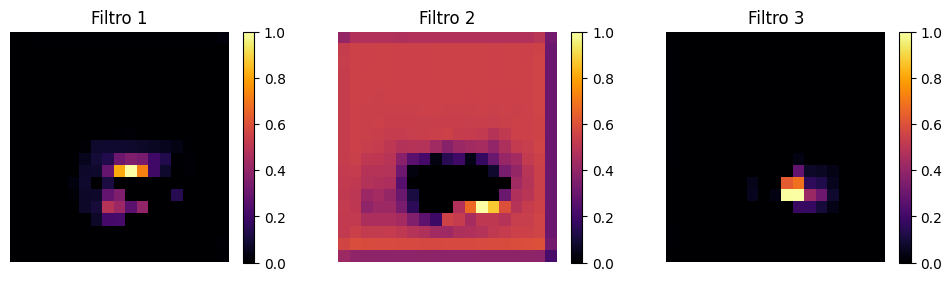

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# Função para normalizar as ativações
def normalize_activation(activation):
    return (activation - np.min(activation)) / (np.max(activation) - np.min(activation))

# Visualiza as ativações da primeira camada convolucional
fig1 = plt.figure(figsize=(12, 3))  # Ajuste o tamanho da figura
gs = gridspec.GridSpec(1, 3) # Crie um grid de 1x3
layer_activation = activations[0]
for i in range(3):  # Visualiza apenas 3 filtros
    ax = fig1.add_subplot(gs[0, i])  # Adicione cada subplot ao grid
    # Normaliza as ativações para visualização
    normalized_activation = normalize_activation(layer_activation[0, :, :, i])
    # Ajuste o Contraste
    min_val = np.min(normalized_activation)
    max_val = np.max(normalized_activation)
    plt.imshow(normalized_activation, cmap='inferno', aspect='auto', interpolation='nearest', clim=(min_val, max_val)) 
    plt.colorbar()
    plt.title(f"Filtro {i+1}")
    plt.axis("off")
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Visualiza as ativações da segunda camada convolucional
fig2 = plt.figure(figsize=(12, 3)) 
gs = gridspec.GridSpec(1, 3)
layer_activation = activations[4]
for i in range(3):  # Visualiza apenas 3 filtros
    ax = fig2.add_subplot(gs[0, i])
    # Normaliza as ativações para visualização
    normalized_activation = normalize_activation(layer_activation[0, :, :, i])
    # Ajuste o Contraste
    min_val = np.min(normalized_activation)
    max_val = np.max(normalized_activation)
    plt.imshow(normalized_activation, cmap='inferno', aspect='auto', interpolation='nearest', clim=(min_val, max_val)) 
    plt.colorbar()
    plt.title(f"Filtro {i+1}")
    plt.axis("off")
plt.subplots_adjust(hspace=0.3, wspace=0.2)

# Visualiza as ativações da terceira camada convolucional
fig3 = plt.figure(figsize=(12, 3)) 
gs = gridspec.GridSpec(1, 3)
layer_activation = activations[8]
for i in range(3):  # Visualiza apenas 3 filtros
    ax = fig3.add_subplot(gs[0, i])
    # Normaliza as ativações para visualização
    normalized_activation = normalize_activation(layer_activation[0, :, :, i])
    # Ajuste o Contraste
    min_val = np.min(normalized_activation)
    max_val = np.max(normalized_activation)
    plt.imshow(normalized_activation, cmap='inferno', aspect='auto', interpolation='nearest', clim=(min_val, max_val)) 
    plt.colorbar()
    plt.title(f"Filtro {i+1}")
    plt.axis("off")
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()

In [32]:
import sys
print(sys.path)  # Mostre o caminho do seu ambiente Python
from grad_cam import __version__
print(f"Versão do grad-cam: {__version__}")

['C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\stefa\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\setuptools\\_vendor']


ModuleNotFoundError: No module named 'grad_cam'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from grad_cam import visualize_cam 
from tqdm import tqdm  # Importe a biblioteca tqdm para a barra de progresso

# Carregue o modelo treinado
loaded_model = load_model('seu_modelo.h5')  # Substitua 'seu_modelo.h5' pelo nome do seu arquivo de modelo

# Supondo que você tenha os dados de teste carregados em `x_test` e `Y_test_augmented`
# ...

# Defina os limites para classificar exemplos como "bons" ou "ruins"
threshold_good = 0.95  # Limite para exemplos "bons" (alta probabilidade)
threshold_bad = 0.50  # Limite para exemplos "ruins" (baixa probabilidade)

# Calcule as probabilidades de saída para os dados de teste
prob = loaded_model.predict(x_test)

# Crie listas para armazenar os índices dos exemplos classificados
example_i_TP = []
example_i_FP = []
example_i_TN = []
example_i_FN = []
bad_example_i_TP = []
bad_example_i_FP = []
bad_example_i_TN = []
bad_example_i_FN = []

# Classifique os exemplos de acordo com as probabilidades de saída e os rótulos reais
for i in tqdm(range(len(prob)), desc="Classificando exemplos"):  # Use tqdm para a barra de progresso
    if prob[i] > threshold_good and Y_test_augmented[i] == 1:
        example_i_TP.append(i)
    if prob[i] > threshold_good and Y_test_augmented[i] == 0:
        example_i_FP.append(i)
    if prob[i] < (1 - threshold_good) and Y_test_augmented[i] == 0:
        example_i_TN.append(i)
    if prob[i] < (1 - threshold_good) and Y_test_augmented[i] == 1:
        example_i_FN.append(i)

    if threshold_bad < prob[i] < (1 - threshold_bad) and Y_test_augmented[i] == 1:
        bad_example_i_TP.append(i)
    if threshold_bad < prob[i] < (1 - threshold_bad) and Y_test_augmented[i] == 0:
        bad_example_i_FP.append(i)
    if threshold_bad < prob[i] < (1 - threshold_bad) and Y_test_augmented[i] == 0:
        bad_example_i_TN.append(i)
    if threshold_bad < prob[i] < (1 - threshold_bad) and Y_test_augmented[i] == 1:
        bad_example_i_FN.append(i)

# Defina a função find_layer_idx
def find_layer_idx(model, layer_name):
    for idx, layer in enumerate(model.layers):
        if layer.name == layer_name:
            return idx
    return -1

# Configure o formato de dados `channels_first` no backend do Keras
K.set_image_data_format('channels_first')

# Encontre a última camada convolucional
penultimate_layer = find_layer_idx(loaded_model, 'conv2d_3')  # Substitua 'conv2d_3' pelo nome da sua última camada convolucional
class_idx = 0  # Posição da classe na camada de saída (0 para saída unidimensional)
layer_idx = -1  # Localização da camada de saída

# Crie listas de exemplos de alta e baixa probabilidade
example_list = [
    example_i_TP[22], example_i_TP[2], example_i_TP[4], example_i_TP[5],
    example_i_FP[1], example_i_FP[7], example_i_FP[3], example_i_FP[4],
    example_i_TN[2], example_i_TN[3], example_i_TN[11], example_i_TN[5],
    example_i_FN[1], example_i_FN[2], example_i_FN[15], example_i_FN[5],
]

bad_example_list = [
    bad_example_i_TP[22], bad_example_i_TP[2], bad_example_i_TP[4], bad_example_i_TP[5],
    bad_example_i_FP[1], bad_example_i_FP[7], bad_example_i_FP[3], bad_example_i_FP[4],
    bad_example_i_TN[13], bad_example_i_TN[20], bad_example_i_TN[11], bad_example_i_TN[5],
    bad_example_i_FN[1], bad_example_i_FN[7], bad_example_i_FN[15], bad_example_i_FN[5],
]

# Visualize o mapa de calor (grad-CAM) para os exemplos selecionados
fig1 = plt.figure(figsize=(7, 7))
fig1.suptitle("TP, FP, TN e FN (de cima para baixo) exemplos de alta probabilidade (grad-CAMs da última camada convolucional)")

for i in range(16):
    grads = visualize_cam(
        loaded_model, layer_idx, filter_indices=0, 
        seed_input=x_test[example_list[i]], penultimate_layer_idx=penultimate_layer,
        backprop_modifier='guided'
    )
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(grads, aspect='auto', cmap='viridis')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

fig2 = plt.figure(figsize=(7, 7))
fig2.suptitle("TP, FP, TN e FN (de cima para baixo) exemplos de baixa probabilidade (grad-CAMs da última camada convolucional)")

for i in range(16):
    grads = visualize_cam(
        loaded_model, layer_idx, filter_indices=0, 
        seed_input=x_test[bad_example_list[i]], penultimate_layer_idx=penultimate_layer,
        backprop_modifier='guided'
    )
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.imshow(grads, aspect='auto', cmap='viridis')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [ ]:
# Bootstraping is used to show errors of different clasificaiton scoring methods. 
# We make 1000 bootstraping resamples and recalculate AUC, accuracy etc.
# Then we find 95% CI for these values.

y_pred = pred # output class 0 or 1
y_prob = prob # output probability between 0 and 1
y_true = y_test # true class 0 or 1

n_bootstraps = 1000
rng_seed = 3  # controls reproducibility
bootstrapped_auc = []
bootstrapped_accuracy = []
bootstrapped_precision = []
bootstrapped_recall = []
bootstrapped_f1 = []
bootstrapped_brier = []
bootstrapped_fpr = []
bootstrapped_tpr = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_prob) - 1, len(y_prob))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score_auc = roc_auc_score(y_true[indices], y_prob[indices])
    bootstrapped_auc.append(score_auc)
   
    score_acc = accuracy_score(y_true[indices], y_pred[indices])
    bootstrapped_accuracy.append(score_acc)
    
    score_precision = precision_score(y_true[indices], y_pred[indices])
    bootstrapped_precision.append(score_precision)
    
    score_recall = recall_score(y_true[indices], y_pred[indices])
    bootstrapped_recall.append(score_recall)
    
    score_f1 = f1_score(y_true[indices], y_pred[indices])
    bootstrapped_f1.append(score_f1)
    
    score_brier = brier_score_loss(y_true[indices], y_prob[indices])
    bootstrapped_brier.append(score_brier)
    
    fpr_score, tpr_score, thresholds_score = metrics.roc_curve(y_true[indices], y_prob[indices], pos_label=1)
    bootstrapped_fpr.append(fpr_score)
    bootstrapped_tpr.append(tpr_score)

In [ ]:
# we can plot histograms to see the bootstraped values
# change to "bootstrapped_accuracy,bootstrapped_precision,bootstrapped_recall,
# bootstrapped_f1,bootstrapped_brier", for other histograms
plt.hist(bootstrapped_auc, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [ ]:
sorted_auc = np.array(bootstrapped_auc)
sorted_acc = np.array(bootstrapped_accuracy)
sorted_precision = np.array(bootstrapped_precision)
sorted_recall = np.array(bootstrapped_recall)
sorted_f1 = np.array(bootstrapped_f1)
sorted_brier = np.array(bootstrapped_brier)

sorted_auc.sort()
sorted_acc.sort()
sorted_precision.sort()
sorted_recall.sort()
sorted_f1.sort()
sorted_brier.sort()

# Computing the lower and upper bound of the 95% confidence interval
confidence_lower_auc = sorted_auc[int(0.025 * len(sorted_auc))]
confidence_upper_auc = sorted_auc[int(0.975 * len(sorted_auc))]

confidence_lower_acc = sorted_acc[int(0.025 * len(sorted_acc))]
confidence_upper_acc = sorted_acc[int(0.975 * len(sorted_acc))]
                                 
confidence_lower_precision = sorted_precision[int(0.025 * len(sorted_precision))]
confidence_upper_precision = sorted_precision[int(0.975 * len(sorted_precision))]
                                 
confidence_lower_recall = sorted_recall[int(0.025 * len(sorted_recall))]
confidence_upper_recall = sorted_recall[int(0.975 * len(sorted_recall))]
                                       
confidence_lower_f1 = sorted_f1[int(0.025 * len(sorted_f1))]
confidence_upper_f1 = sorted_f1[int(0.975 * len(sorted_f1))]
                                 
confidence_lower_brier = sorted_brier[int(0.025 * len(sorted_brier))]
confidence_upper_brier = sorted_brier[int(0.975 * len(sorted_brier))]


print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_prob)))
print("95% Confidence interval for the AUC score: [{:0.3} - {:0.3}]".format(
    confidence_lower_auc, confidence_upper_auc))
print("95%CI AUC errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_auc - roc_auc_score(y_true, y_prob), 
    confidence_upper_auc - roc_auc_score(y_true, y_prob)))

print("Original Accuracy: {:0.3f}".format(accuracy_score(y_true, y_pred)))
print("95% Confidence interval for the Accuracy: [{:0.3} - {:0.3}]".format(
    confidence_lower_acc, confidence_upper_acc))
print("95%CI Accuracy errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_acc - accuracy_score(y_true, y_pred), 
    confidence_upper_acc - accuracy_score(y_true, y_pred)))

print("Original Precision: {:0.3f}".format(precision_score(y_true, y_pred)))
print("95% Confidence interval for the Precision: [{:0.3} - {:0.3}]".format(
    confidence_lower_precision, confidence_upper_precision))
print("95%CI Precision errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_precision - precision_score(y_true, y_pred), 
    confidence_upper_precision - precision_score(y_true, y_pred)))

print("Original Recall: {:0.3f}".format(recall_score(y_true, y_pred)))
print("95% Confidence interval for the Recall: [{:0.3} - {:0.3}]".format(
    confidence_lower_recall, confidence_upper_recall))
print("95%CI Recall errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_recall - recall_score(y_true, y_pred), 
    confidence_upper_recall - recall_score(y_true, y_pred)))

print("Original F1 score: {:0.3f}".format(f1_score(y_true, y_pred)))
print("95% Confidence interval for the F1 score: [{:0.3} - {:0.3}]".format(
    confidence_lower_f1, confidence_upper_f1))
print("95%CI F1 score errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_f1 - f1_score(y_true, y_pred), 
    confidence_upper_f1 - f1_score(y_true, y_pred)))

print("Original Brier score: {:0.3f}".format(brier_score_loss(y_true, y_prob)))
print("95% Confidence interval for the Brier score: [{:0.3} - {:0.3}]".format(
    confidence_lower_brier, confidence_upper_brier))
print("95%CI Brier score errors are: [{:0.3} , {:0.3}]".format(
    confidence_lower_brier - brier_score_loss(y_true, y_prob), 
    confidence_upper_brier - brier_score_loss(y_true, y_prob)))

In [ ]:
# We can also find 95%CI (in vertical direction) for the ROC curve

tprs = []
base_fpr = np.linspace(0, 1, 1001)

for i in range(len(bootstrapped_fpr)):  
    tpr1 = interp(base_fpr, bootstrapped_fpr[i], bootstrapped_tpr[i])
    tpr1[0] = 0.0
    tprs.append(tpr1)

tprs = np.array(tprs)
mean = tprs.mean(axis=0) # mean tpr
std = tprs.std(axis=0) # standard deviation of tpr

# 95%CI can be calculated as:
tprs_upper_95 = mean + 1.96*std  # 1.96 is z-score for 95%CI
tprs_lower_95 = mean - 1.96*std


# Plots ROC curve with 95%CI in the vertical direction
figsize=(6,6)
fig, axis1 = plt.subplots(figsize=figsize)
x_onetoone = y_onetoone = [0, 1]

prist = plt.plot(fpr, tpr, 'navy', linewidth=2, label='pristine images')
prist_fill = plt.fill_between(base_fpr, tprs_lower_95, tprs_upper_95, color='deepskyblue', alpha=0.9, label='95%CI pristine images')
line = plt.plot(x_onetoone, y_onetoone, 'k--',linewidth=1, label="1-1")


plt.legend(loc='lower right')
plt.xlabel("False Positive (1 - Specificity)")
plt.ylabel("True Positive (Selectivity)")
plt.tight_layout()